In [1]:
import os
import numpy as onp
os.chdir("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/amigo/src/amigo")

# autodiff
import jax
from jax import numpy as np, random as jr, scipy as jsp
from zodiax.experimental import deserialise

# visualisation
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.transforms import Affine2D
import ehtplot
import scienceplots
from geckos_colourmap import geckos_div
import datetime

# astronomy
import webbpsf

# optimisation
import optax

# AMIGO
import amigo
from amigo.core import AMIOptics, SUB80Ramp, BaseModeller
from amigo.fitting import optimise

from io_funcs import initialise_disk, SimpleIoSource, ComplexIoSource, add_noise_to_ramp, DefinitelyRealIo, get_filter_spectrum
from io_funcs import sim_io_model_fn as model_fn
from plotting import plot_io_with_truth, plot_params

# files
from zodiax.experimental import deserialise

plt.style.use(['science', 'bright', 'no-latex'])

# matplotlib parameters
%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 8

inferno = colormaps["inferno"]
viridis = colormaps["viridis"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
viridis.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_debug_nans", True)

sunset_dark = geckos_div(variation="geckos_sunset_darkred")
sunset = geckos_div(variation="geckos_sunset")

dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


In [2]:
n_ios = 1
roll_angle_degrees = 26.5  # deg
ios = [DefinitelyRealIo(night_day_ratio=1, volc_contrast=1e-1, seed=2, n_volcanoes=3) for i in range(n_ios)]

In [3]:
# np.save("fake_io_noterm.npy", ios[1].data)
# canon_io = np.load("fake_io_noterm.npy")
canon_io = ios[0]

In [4]:
BFE = deserialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/bfe/PolyBFE_trained.zdx")
pupil_mask = deserialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/bfe/PolyBFE_AMI_mask.zdx")

In [5]:
key = jr.PRNGKey(0)
ngroups = 3
filt = "F430M"
eps = 1e-16

# Get webbpsf optical system for OPD
inst = webbpsf.NIRISS()
# inst.load_wss_opd_by_date(files[0][0].header["DATE-BEG"], verbose=False)
opd = np.array(inst.get_optical_system().planes[0].opd)

# Get dLux optical system
optics = AMIOptics(
    opd=opd,
    pupil_mask=pupil_mask,
    # radial_orders=[0, 1, 2, 3],
    normalise=True,
    )
optics = optics.set("coefficients", 5*jr.normal(key, optics.coefficients.shape))
detector = SUB80Ramp()

params = {}
params["one_on_fs"] = 10*jr.normal(key, (ngroups, 80, 2))
params["BFE"] = BFE
# params["aberrations"] = np.zeros(optics.coefficients.shape)
# params["biases"] = np.zeros((80, 80))
# params["BFE"] = PolyBFE(ksize=5, oversample=1, orders=[1, 2])
params["optics"] = optics
params["detector"] = detector
params["source"] = ComplexIoSource(
    position=jr.uniform(key, (2,), minval=-0.5, maxval=0.5),
    log_flux=jr.uniform(key, (1,), minval=6.9, maxval=7.1),
    volc_contrast=1e-1,
    log_volcanoes=np.log10(canon_io.volcanoes / canon_io.volcanoes.sum() + eps),
    # distribution=canon_io.data,
    spectrum=get_filter_spectrum(filt, file_path="/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/data/niriss_filters/"),
)

true_model = BaseModeller(params)

In [6]:
clean_int = model_fn(true_model, ngroups=ngroups)
data = add_noise_to_ramp(clean_int)  # adding photon noise to ramp
io_mask = np.where(initialise_disk()==0, False, True)

## Optimisation

In [7]:
def simple_norm_fn(model, args={}):
    """
    Method for returning a new source object with a normalised total
    spectrum and source distribution.

    Returns
    -------
    source : Source
        The source object with the normalised spectrum and distribution.
    """
    spectrum = model.spectrum.normalise()
    distribution = np.maximum(model.distribution, 0.0)    

    # applying mask
    distribution = np.where(args['mask'], distribution, args['mask'])
    if distribution.sum != 0:
        distribution /= distribution.sum()

    return model.set(
        [
            "spectrum",
            "distribution",
            ],
        [
            spectrum,
            distribution,
            ],
        )

def complex_norm_fn(model, args={}):
    """
    Method for returning a new source object with a normalised total
    spectrum and source distribution.

    Returns
    -------
    source : Source
        The source object with the normalised spectrum and distribution.
    """
    spectrum = model.spectrum.normalise()
    volc_contrast = np.clip(model.volc_contrast, 0., 1.)

    volcanoes = np.power(10, model.log_volcanoes)
    volcanoes /= volcanoes.sum()

    log_volcanoes = np.log10(volcanoes)    

    # applying mask
    volcanoes = np.where(args['mask'], volcanoes, args['mask'])
    if volcanoes.sum != 0:
        volcanoes /= volcanoes.sum()

    return model.set(
        [
            "spectrum",
            "volc_contrast",
            "log_volcanoes",
            ],
        [
            spectrum,
            volc_contrast,
            log_volcanoes,
            ],
        )

# def grad_fn(grads, args={}, optimisers={}):
#     return grads.set('distribution', np.where(args['mask'], grads, args['mask']))

def L1_loss(model):
    return np.nansum(np.abs(model.source.distribution))

def TV_loss(model):
    # return np.sqrt(np.nansum(np.abs(model.source.distribution[1:, :] - model.source.distribution[:-1, :])))
    pass

def maxent_loss(model):
    pass

def loss_fn(model, args={}):
    data = args["data"]
    ramp = model_fn(model, ngroups=args["ngroups"])
    loss = np.log10(-jsp.stats.norm.logpdf(ramp, data).sum())
    loss += args["L1"] * L1_loss(model)  # L1s
    # loss += args["TV"] * TV_loss(model)  # TV
    # loss += args["maxent"] * maxent_loss(model)  # maxent
    return loss


delay = lambda lr, s: optax.piecewise_constant_schedule(lr * 1e-16, {s: 1e16})
opt = lambda lr, start: optax.sgd(delay(lr, start), nesterov=True, momentum=0.5)
adam_opt = lambda lr, start: optax.adam(delay(lr, start))
clip = lambda optimiser, v: optax.chain(optimiser, optax.clip(v))

In [8]:
initial_model = true_model.set(
    [
        "position",
        "log_flux",
        "log_volcanoes",
        "volc_contrast",
        # "distribution",
        "optics.coefficients",
        "one_on_fs"
    ],
    [
        true_model.position + 0.1*jr.normal(jr.PRNGKey(1), shape=(2,)),
        true_model.log_flux - 0.1,
        np.log10(initialise_disk(normalise=True)),
        # true_model.volcanoes,
        0.01,
        # np.zeros_like(true_model.optics.coefficients),
        true_model.optics.coefficients,
        # np.zeros_like(true_model.one_on_fs),
        true_model.one_on_fs,
    ],
)

L1 = 0.

config = {
    # # Crude solver
    "position": optax.adam(delay(2e-3, 0), b1=0.7),
    "log_flux": optax.adam(delay(5e-3, 0), b1=0.7),
    # # "position": optax.adam(delay(5e-4, 0), b1=0.7),
    # # "log_flux": optax.adam(delay(2e-3, 0), b1=0.7),
    "volc_contrast": optax.adam(delay(2e-3, 0), b1=0.7),
    "log_volcanoes": optax.adam(delay(5e-2, 10), b1=0.7),
    # "distribution": optax.adam(delay(5e-6, 50), b1=0.7),
    # "optics.coefficients": opt(1e3, 10),
    # "one_on_fs": opt(2e4, 15),
}

# params = list(config.keys())

# Optimisation
final_model, losses, params_out, opt_state = optimise(
    initial_model,
    # data,
    {"model_fn": model_fn, "ngroups": ngroups, "data": data, "mask": io_mask, "L1": L1},
    loss_fn,
    10,
    config,
    norm_fn=complex_norm_fn,
    # grad_fn=grad_fn,
    print_grads=False,
    return_state=True,
    nan_method="none",
)

Step fn compiling...
Compile Time: 0:00:07
Initial Loss: 8.63


Loss: 8.63, Change: 0.0:  10%|#         | 1/10 [00:00<?, ?it/s]

Full Time: 0:00:23
Final Loss: 8.20


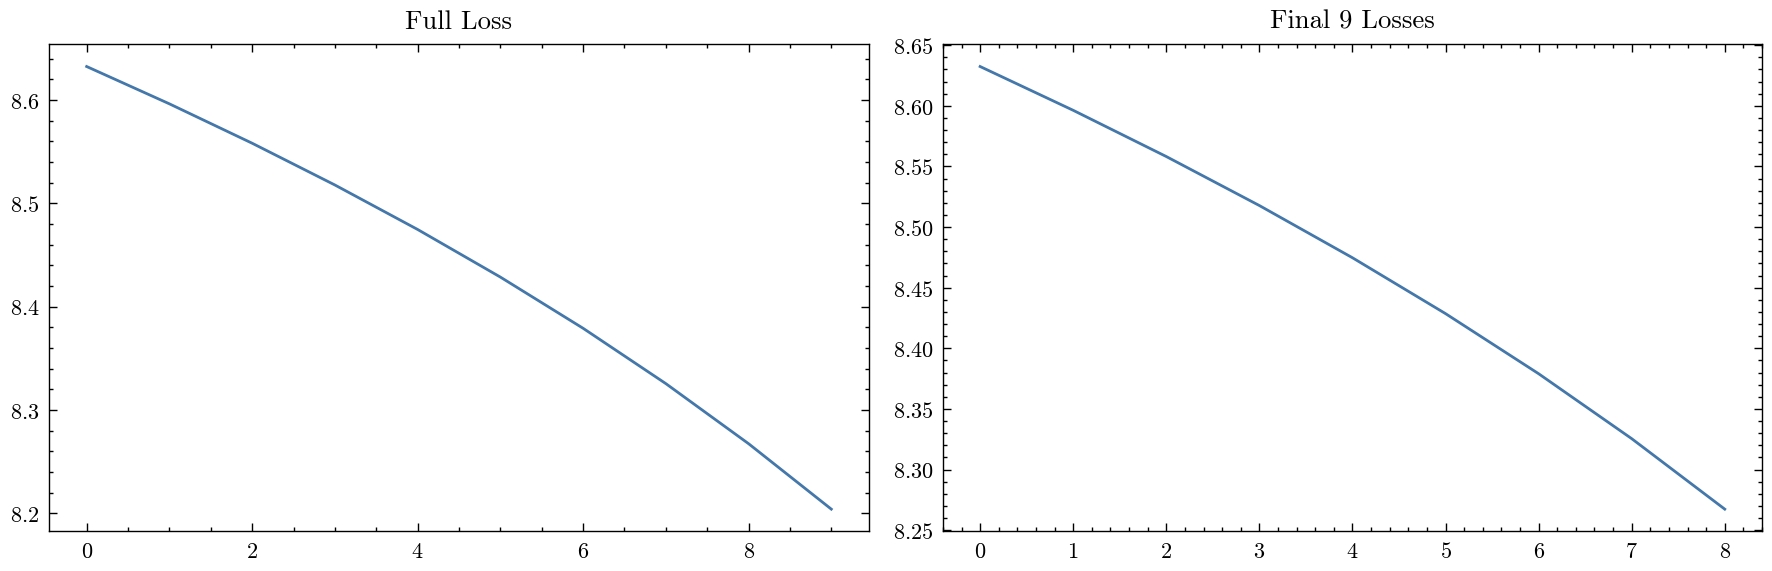

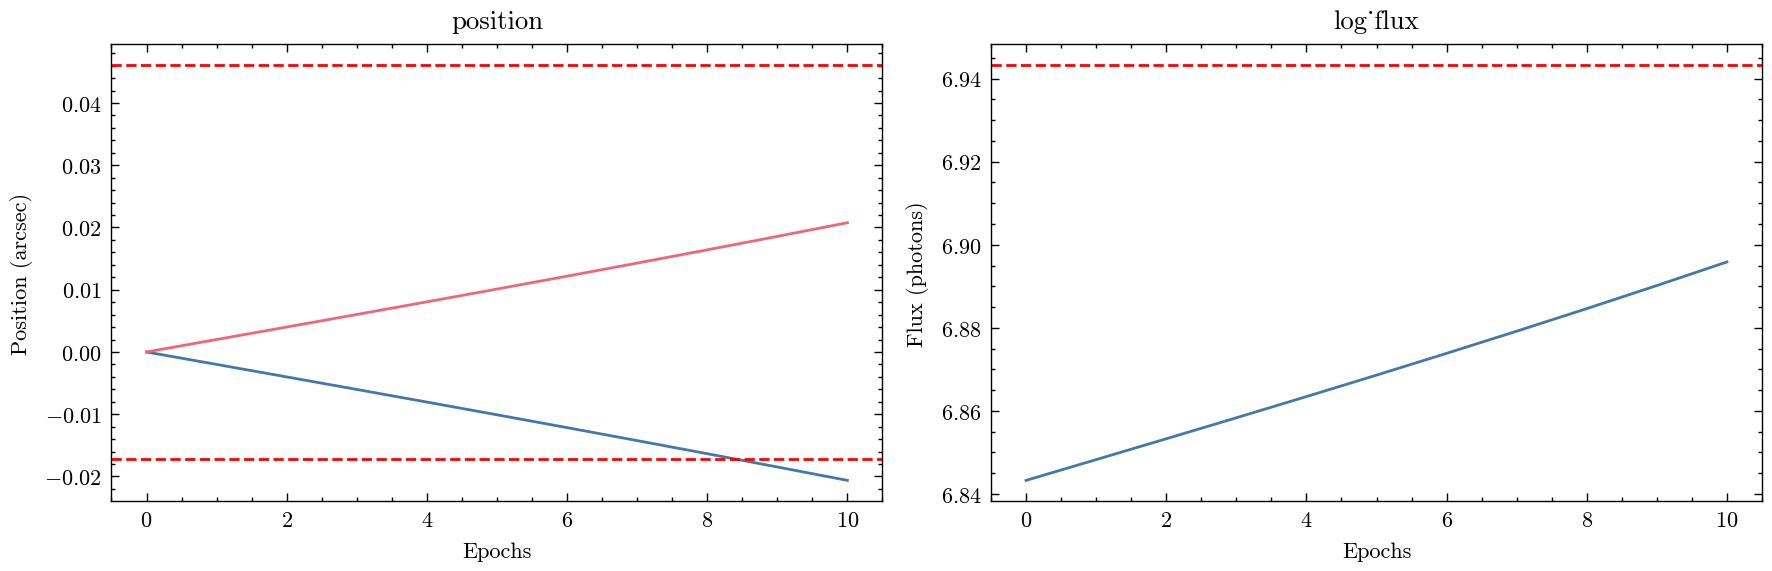

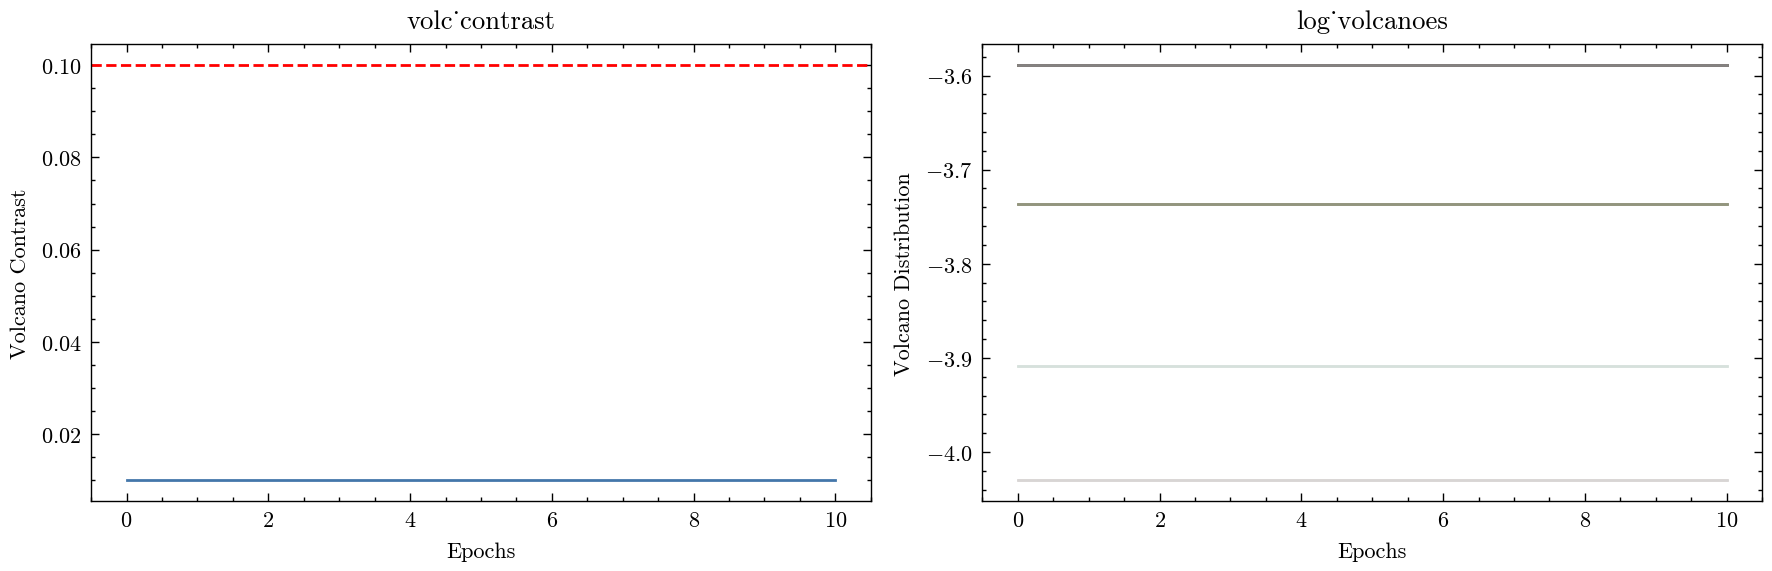

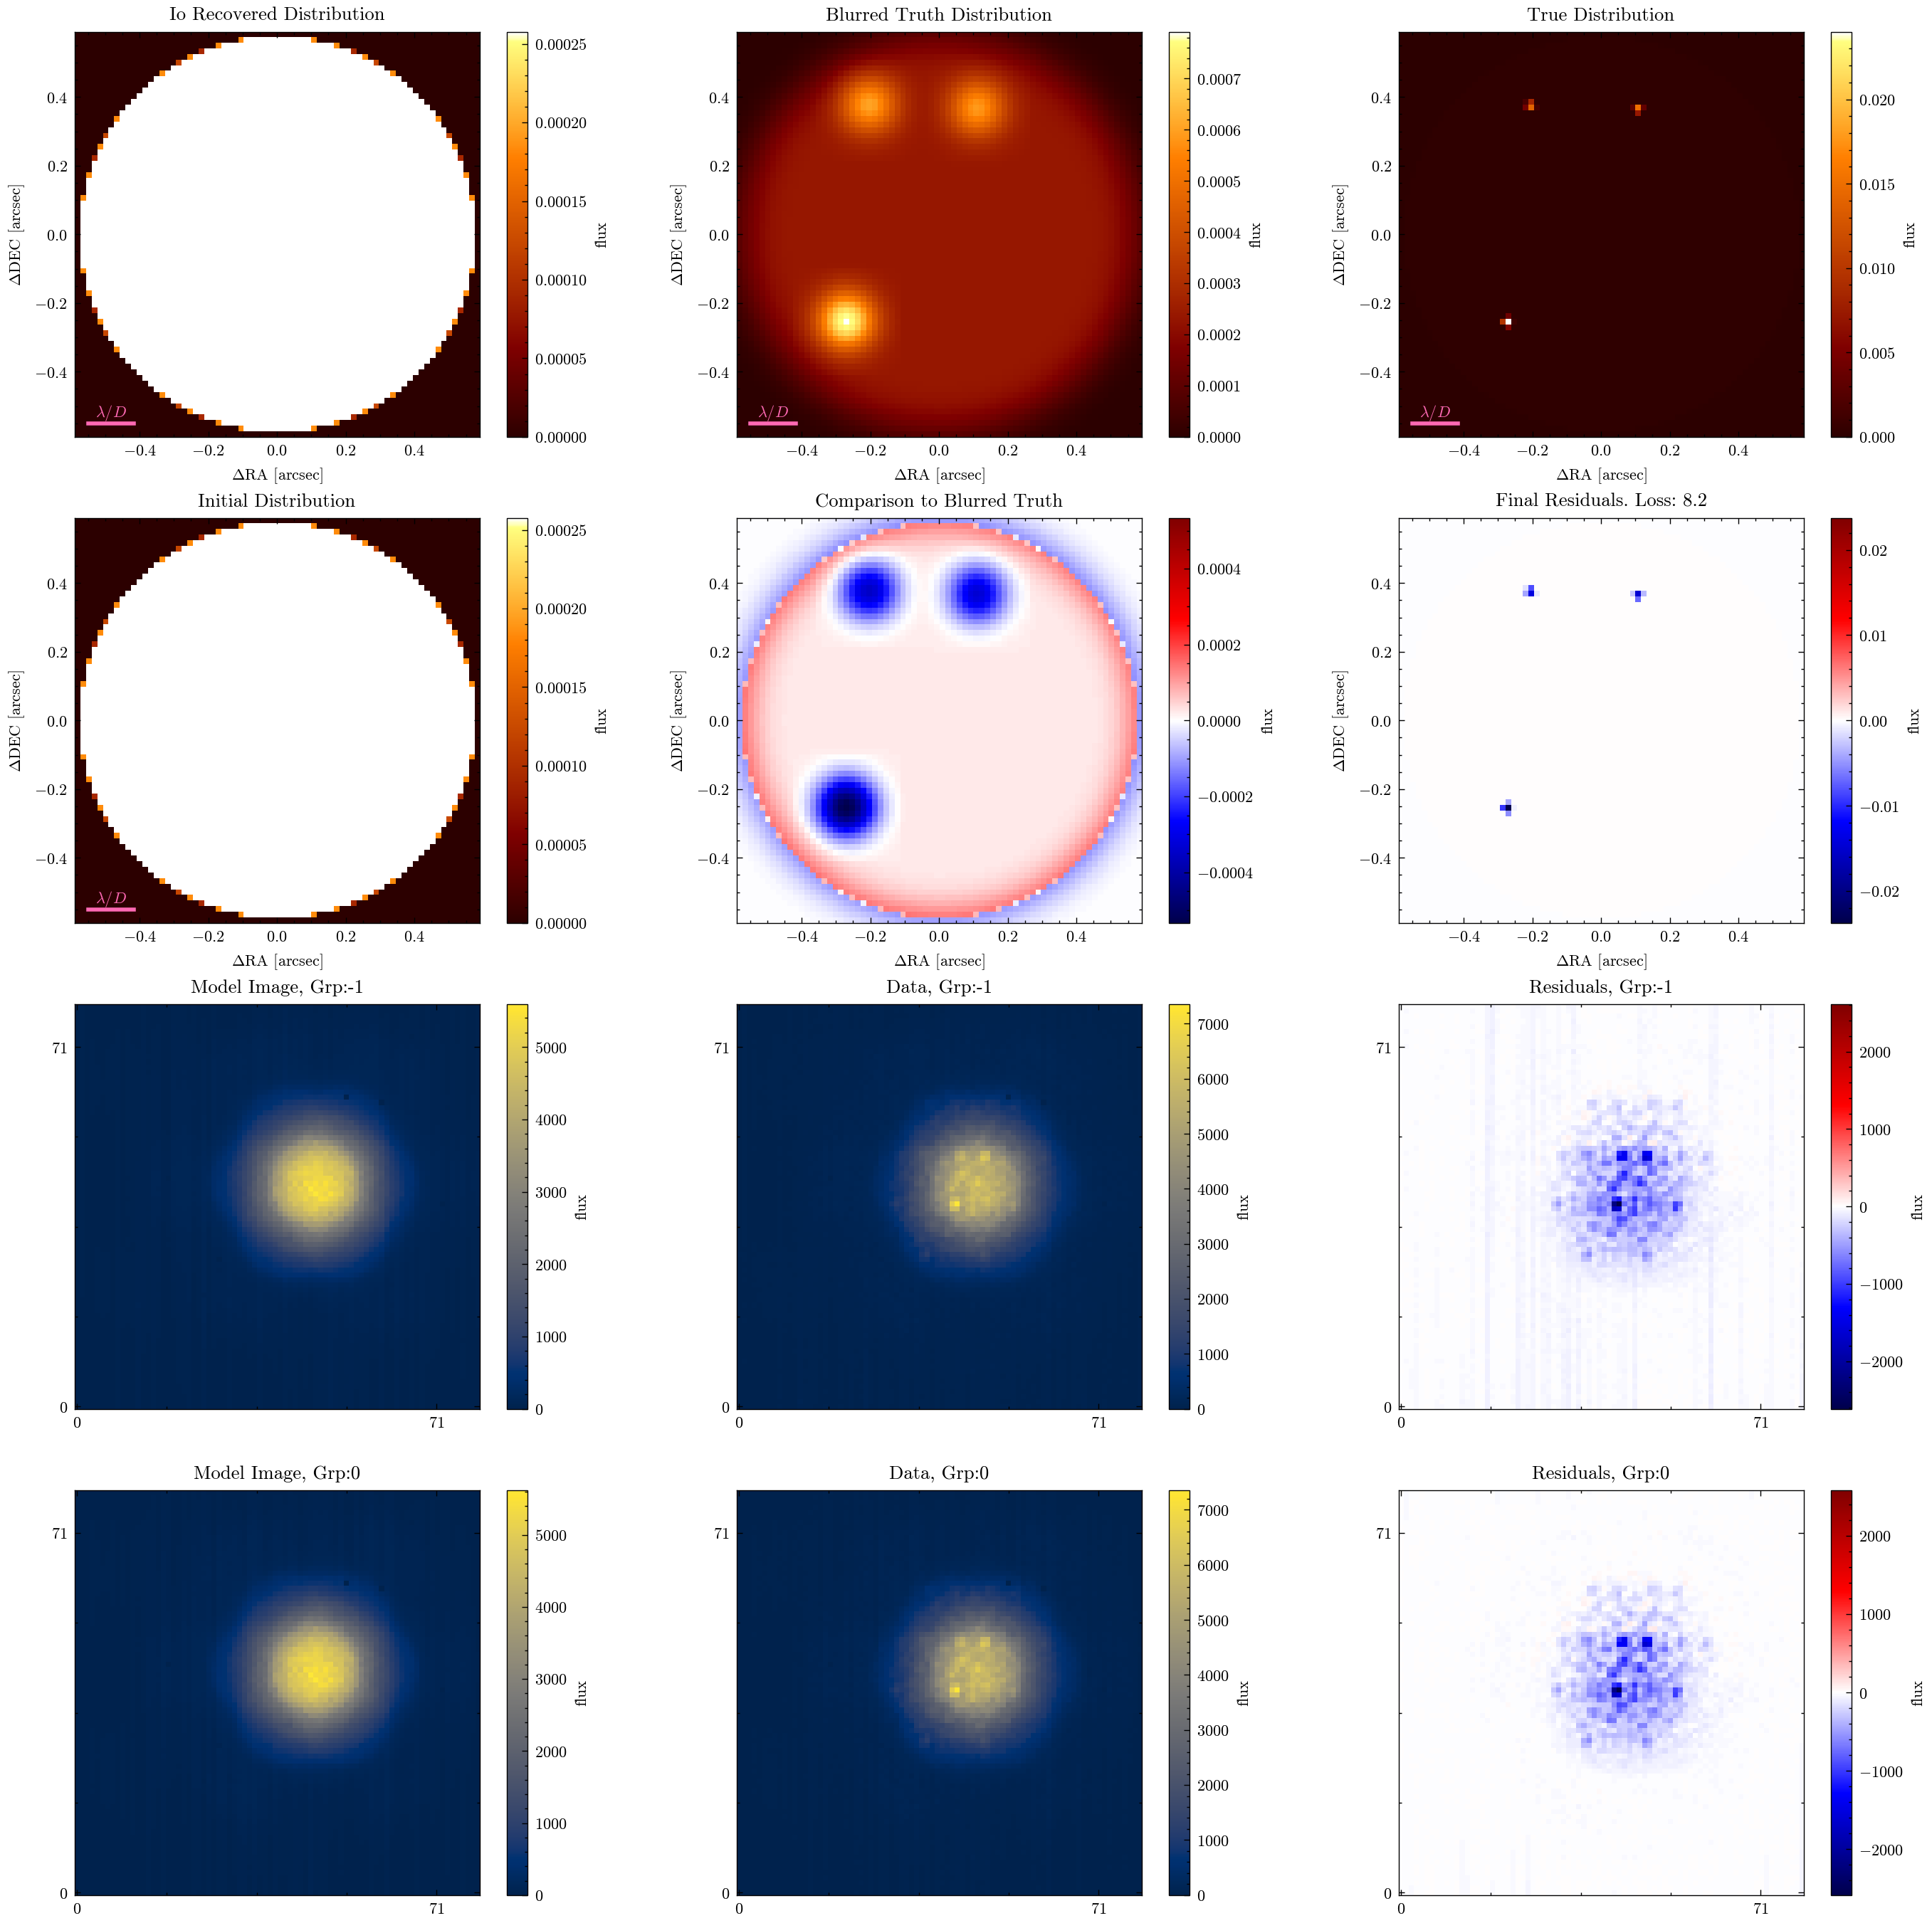

In [9]:
plot_params(np.array(losses), params_out, save=None, true_model=true_model)

plot_io_with_truth(
    final_model,
    model_fn,
    data,
    losses,
    ngroups,
    opt_state,
    initial_distribution=initial_model.source.distribution,
    # roll_angle_degrees=roll_angle_degrees,
    # cmap="inferno",
    true_model=true_model,
    save=None,
    )
